In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import helper
from helper import *

In [2]:
df = load_and_preprocess()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby(df.datetime.dt.date).agg('mean')
df.head()

,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
datetime,,,,,,,,,,,,,,
2012-10-01,75.727273,963.920433,285.887980,235.727273,3.272727,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.272727
2012-10-02,50.287179,1014.996834,286.937931,260.583333,1.666667,0.125000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.375000
2012-10-03,78.752564,1015.283302,287.374583,227.583333,1.333333,0.125000,0.000000,0.083333,0.0,0.0,0.0,0.125,0.0,0.666667
2012-10-04,83.305769,1017.194770,286.860833,101.583333,1.000000,0.083333,0.000000,0.208333,0.0,0.0,0.0,0.250,0.0,1.083333
2012-10-05,79.258333,1017.688516,287.535208,66.333333,1.708333,0.333333,0.083333,0.500000,0.0,0.0,0.0,0.000,0.0,2.083333


In [3]:
df = df.dropna()

In [8]:
df2 = df[['Temperature']].reset_index().rename(columns = {'datetime': 'Date'})
df2['Date'] = pd.to_datetime(df2['Date'])

In [9]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df2['Date'], y=df2['Temperature'], name='Temperature (Kelvin)'))
fig.update_layout(showlegend=True)
fig.show()

In [10]:
train, test = df2.loc[df2['Date'] <= '2016-01-01'], df2.loc[df2['Date'] > '2016-01-01']
train.shape, test.shape

((1188, 2), (699, 2))

In [11]:
sc = StandardScaler()
train['Temperature'] = sc.fit_transform(train[['Temperature']])
test['Temperature'] = sc.transform(test[['Temperature']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
train

,Date,Temperature
0,2012-10-01,0.516831
1,2012-10-02,0.606133
2,2012-10-03,0.643271
3,2012-10-04,0.599575
4,2012-10-05,0.656933
...,...,...
1183,2015-12-28,-1.195804
1184,2015-12-29,-1.351696
1185,2015-12-30,-1.201776
1186,2015-12-31,-0.819025


In [13]:
def create_sequences(X, y, time_steps = 24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
X_train, y_train = create_sequences(train[['Temperature']], train[['Temperature']], 24)
X_test, y_test = create_sequences(test[['Temperature']], test[['Temperature']], 24)

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, input_shape = X_train.shape[1:]))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(X_train.shape[1]))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(X_train.shape[2])))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 32)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 32)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
____________________________________________________

In [16]:
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.1, batch_size = 32, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
33/33 [==============================] - 3s 27ms/step - loss: 0.5179 - val_loss: 0.3245
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 0.3843 - val_loss: 0.3217
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3707 - val_loss: 0.3195
Epoch 4/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3560 - val_loss: 0.3109
Epoch 5/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3496 - val_loss: 0.3043
Epoch 6/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3459 - val_loss: 0.3116
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3289 - val_loss: 0.3044
Epoch 8/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3347 - val_loss: 0.3011
Epoch 9/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3314 - val_loss: 0.2986
Epoch 10/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3331 - val_loss: 0.3005

In [17]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis = 1)

<AxesSubplot:ylabel='Count'>

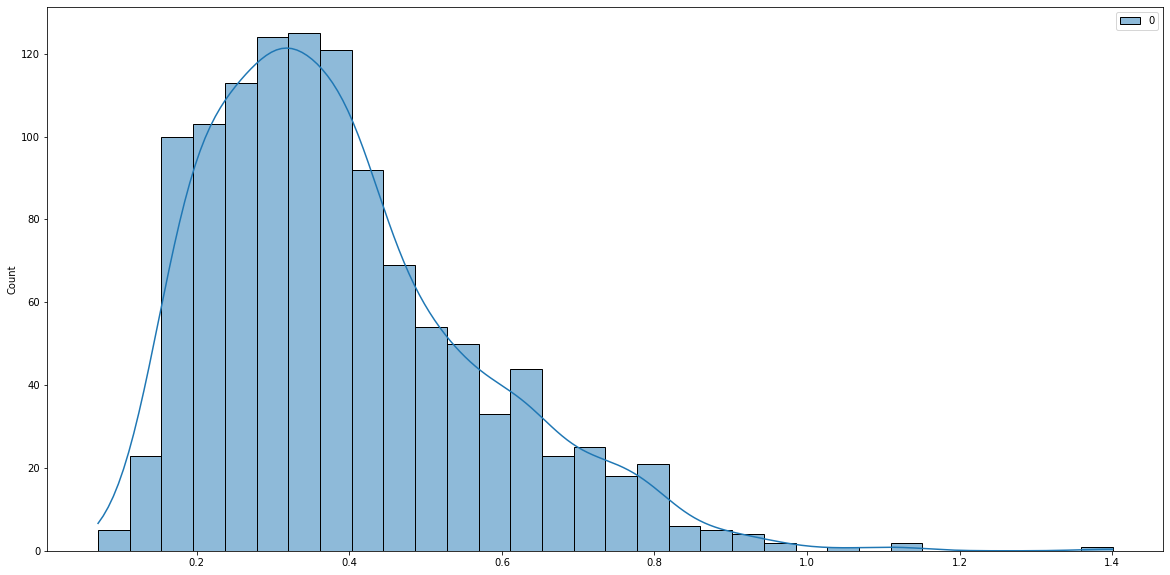

In [18]:
plt.figure(figsize=(20, 10))
sns.histplot(train_mae_loss, kde=True)

<AxesSubplot:ylabel='Count'>

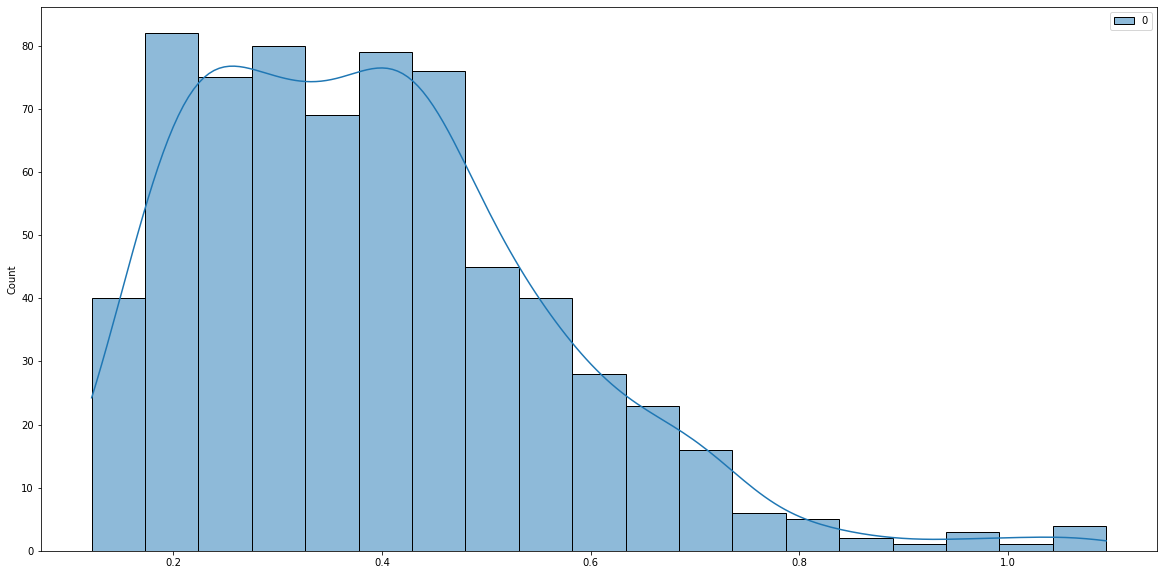

In [19]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

plt.figure(figsize=(20,10))
sns.histplot(test_mae_loss, kde=True)

In [33]:
threshold = np.quantile(train_mae_loss, 0.95)

test_score_df = pd.DataFrame(test[24:])
test_score_df['loss'] = test_mae_loss
test_score_df['anomaly'] = np.where(test_mae_loss>threshold, True, False)
test_score_df['threshold'] = threshold
test_score_df.head()

,Date,Temperature,loss,anomaly,threshold
1212,2016-01-26,-0.698111,0.392646,False,0.737396
1213,2016-01-27,-0.701372,0.473460,False,0.737396
1214,2016-01-28,-1.062883,0.469581,False,0.737396
1215,2016-01-29,-0.635035,0.330941,False,0.737396
1216,2016-01-30,-1.081006,0.571011,False,0.737396


In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name = 'Test MAE'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [35]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(20, 5)

In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=sc.inverse_transform(test_score_df['Temperature']) - 273.15, name = 'Temperature'))
fig.add_trace(go.Scatter(x = anomalies['Date'], y=sc.inverse_transform(anomalies['Temperature']) - 273.15, name = 'Anomaly', mode = 'markers'))
fig.update_layout(showlegend=True, title='Detected Anomalies')
fig.show()